In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib
import warnings
warnings.filterwarnings('ignore')


In [17]:
df = pd.read_csv("./data.csv",sep=";")
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (2861, 11)


,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL
0,1,17.02.2000,0.330,2.77,12.0,12.30,9.50,0.057,154.0,0.454,289.5
1,1,11.05.2000,0.044,3.00,51.6,14.61,17.75,0.034,352.0,0.090,1792.0
2,1,11.09.2000,0.032,2.10,24.5,9.87,13.80,0.173,416.0,0.200,2509.0
3,1,13.12.2000,0.170,2.23,35.6,12.40,17.13,0.099,275.2,0.377,1264.0
4,1,02.03.2001,0.000,3.03,48.8,14.69,10.00,0.065,281.6,0.134,1462.0


In [18]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

df.replace([" ", "?", "NA", "na", "NaN", "nan"], np.nan, inplace=True)

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
non_numeric_cols = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

print("Missing values before:")
print(df.isnull().sum())

valid_numeric_cols = [col for col in numeric_cols if df[col].notna().sum() > 0]

imputer = SimpleImputer(strategy="mean")
numeric_array = imputer.fit_transform(df[valid_numeric_cols])
numeric_data_imputed = pd.DataFrame(numeric_array, columns=valid_numeric_cols)

if non_numeric_cols:
    df_imputed = pd.concat([numeric_data_imputed, df[non_numeric_cols].reset_index(drop=True)], axis=1)
else:
    df_imputed = numeric_data_imputed

print("Missing values after:")
print(df_imputed.isnull().sum())


Missing values before:
id            0
date          0
NH4           3
BSK5          1
Suspended    16
O2            3
NO3           1
NO2           3
SO4          49
PO4          28
CL           49
dtype: int64
Missing values after:
id           0
NH4          0
BSK5         0
Suspended    0
O2           0
NO3          0
NO2          0
SO4          0
PO4          0
CL           0
date         0
dtype: int64


In [21]:
# Create 'Potability' based on domain rules
df_imputed["Potability"] = np.where(
    (df_imputed["O2"] >= 6.0) &
    (df_imputed["NO3"] <= 50) &
    (df_imputed["Suspended"] <= 30) &
    (df_imputed["NH4"] <= 0.5),
    1,  # Safe
    0   # Unsafe
)


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Drop 'Potability' and 'date' before scaling
X = df_imputed.drop(["Potability", "date"], axis=1)
y = df_imputed["Potability"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [24]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    results[name] = {"Accuracy": acc, "ROC AUC": roc}
    print(f"\n{name}\nAccuracy: {acc:.4f}, ROC AUC: {roc:.4f}")



Logistic Regression
Accuracy: 0.9075, ROC AUC: 0.9554

Random Forest
Accuracy: 0.9965, ROC AUC: 0.9999

Gradient Boosting
Accuracy: 0.9965, ROC AUC: 0.9949

SVM
Accuracy: 0.9250, ROC AUC: 0.9776


In [25]:
best_model_name = max(results, key=lambda k: results[k]["ROC AUC"])
best_model = models[best_model_name]
print(f"\n✅ Best Model: {best_model_name}")



✅ Best Model: Random Forest


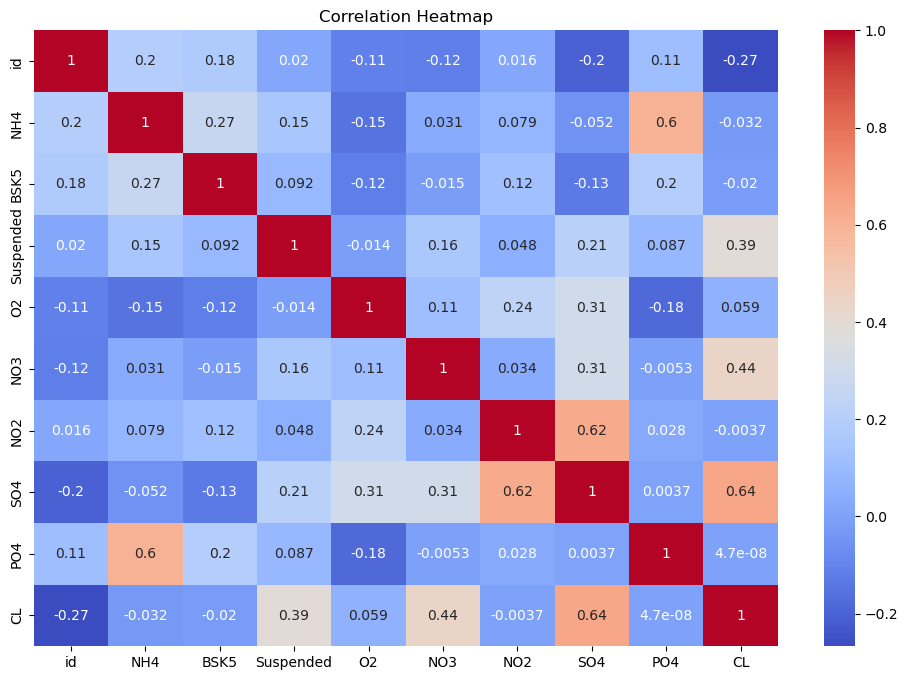

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=["number"])

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [29]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_cols])
df_scaled = pd.DataFrame(scaled_features, columns=numeric_cols)

# Combine with non-numerical columns
df_final = pd.concat([df_scaled, df.drop(columns=numeric_cols).reset_index(drop=True)], axis=1)
df = df_final.copy()
df


,id,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL,date,year
0,-1.599117,-0.268891,-0.606295,-1.651908,0.988582,0.310169,-0.615221,0.997794,-1.185644,0.053699,2000-04-17,2000
1,-1.599117,-0.314956,-1.078452,-1.080980,-0.117608,-0.401029,-0.492497,1.320592,0.966336,0.768524,2000-07-04,2000
2,-1.599117,-0.696035,-1.550610,0.845899,0.558767,-0.074715,-0.467953,0.727626,0.377587,0.820829,2000-11-01,2000
3,-1.599117,-1.005924,-0.880596,-0.581419,1.108530,0.477510,-0.737945,1.018846,-0.860817,0.332655,2001-05-03,2001
4,-1.599117,-0.503402,-0.242059,-0.224589,0.498793,-0.518167,-0.860668,0.057470,1.605839,0.088568,2001-08-06,2001
...,...,...,...,...,...,...,...,...,...,...,...,...
1817,1.742924,-0.570405,-0.966034,-1.651908,1.475039,1.205441,-0.443408,2.659503,0.803922,2.386471,2019-12-04,2019
1818,1.742924,-1.005924,-0.696229,-0.438687,2.637871,0.757805,-1.277928,1.985837,-0.820213,2.507642,2020-03-11,2020
1819,1.742924,-1.005924,-0.885092,0.203606,1.201823,0.598832,-0.909758,2.412492,0.986638,2.265299,2020-05-13,2020
1820,1.742924,-0.817478,0.054726,-0.795517,0.598750,-0.773362,-0.958847,2.552839,0.600905,2.406521,2020-07-01,2020
